## Testing hypothesis 7
---

**_Hypothesis_**: Publishers are very specialized, so no publisher are able to get high scores (> 4.5) in more than 10 categories.

   - **Metric**: N. of times a publisher gets a score > 4.5 in different categories.
    
**Missing Values**:
  
- `publisher`: remove the entire sample
- `review/score`: remove the entire sample
- `categories`: remove the entire sample

**Data Transformation**:

- `categories`: GroupBy categories.
- `publisher`: GroupBy publisher.
- `review/score`: Compute the average review/score for each publisher.

---

In [133]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_hypothesis_7']

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':{
                                     'category':'$categories',
                                     'publisher':'$publisher',
                                     },
                                'avg_score':{'$avg':'$review/score'}
                                }
                           }

# Show average rating for category for each publisher
pipeline_publisher = {'$group': {
               '_id': '$_id.publisher',
               'avg_score/category': {
                    '$push': {
                         'category': '$_id.category',
                         'avg_score': '$avg_score'
                         }
                    }
               }
          }

# Unwind the list of categories
pipeline_unwind = {'$unwind':'$avg_score/category'}

# Count the number of categories with average rating > 4.5
pipeline_counts = {'$project': {
                         'publisher': '$_id',
                         '_id':0,
                         'category':'$avg_score/category.category',
                         'count': {
                              '$sum': {
                                   '$cond': {
                                   
                                        'if':{'$gt': ['$avg_score/category.avg_score', 4.5]},
                                        'then':1,
                                        'else':0
                                   }
                              }
                         }
                    }
               }

# Sum the results for each publisher. If Total > 10, then the hypothesis is False
pipeline_sum = {'$group': {
                    '_id': '$publisher', 
                    'total': {'$sum': '$count'}
                    }
                }

pipeline_sort = {'$sort':{
                         'total':-1
                         }
                }

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_publisher, pipeline_unwind, pipeline_counts, pipeline_sum, pipeline_sort])

df_results = pd.DataFrame(list(results))

In [148]:
df_results.head()

,_id,total
0,Random House,31
1,Oxford University Press USA,30
2,Vintage,23
3,Lulu com,20
4,Bantam,19


<AxesSubplot: title={'center': 'Number of categories with average rating > 4.5 for each publisher'}, xlabel='publisher'>

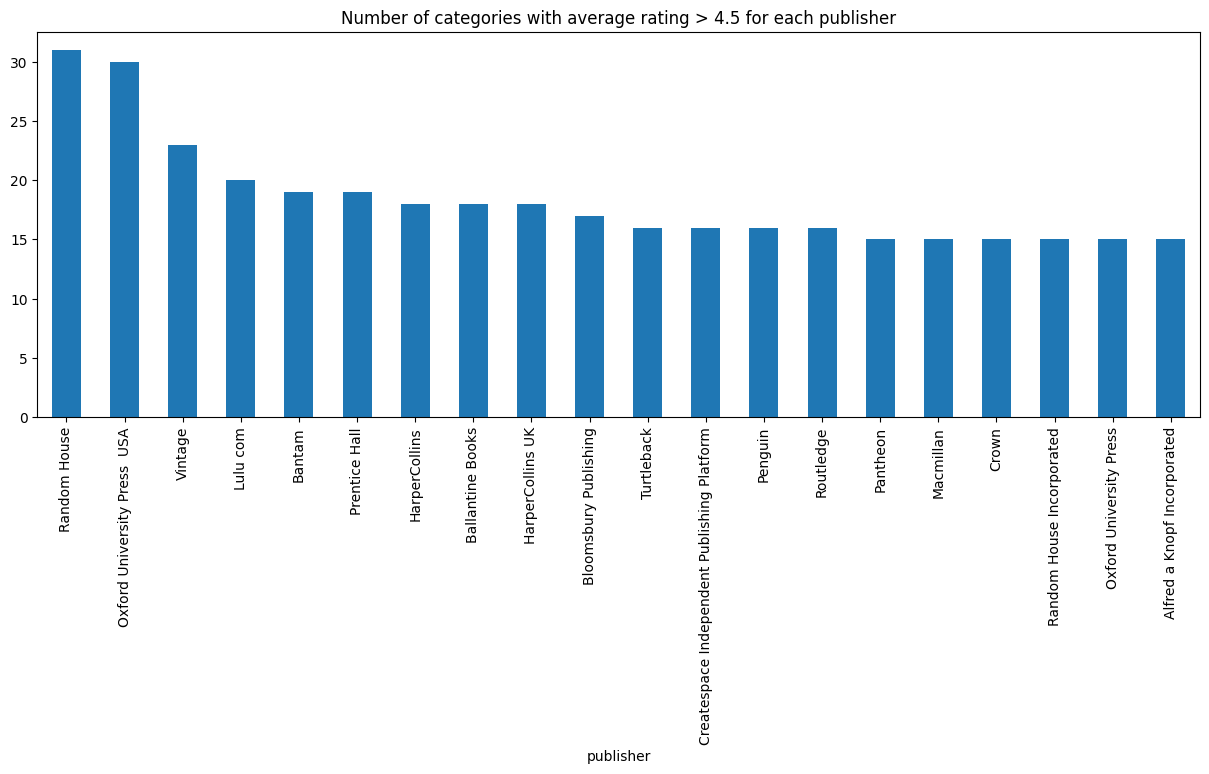

In [146]:
df_results.head(20).plot(x='_id', y='total', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of categories with average rating > 4.5 for each publisher', legend=False)

## Deeper analysis focused on categories and publishers separately
---

### Analysis of categories

In [219]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$categories',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1}
                                }
                           }

pipeline_project = {'$project':{
                         '_id':0,
                         'category':'$_id',
                         'avg_score':1,
                         'count': 1
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2 = pd.DataFrame(list(results_2))

In [220]:
df_results_2.head()

,avg_score,count,category
0,4.335915,7618,Religion
1,4.027335,439,FICTION
2,4.279020,2326,Young Adult Fiction
3,4.360677,768,Poetry
4,4.108939,358,Transportation


<AxesSubplot: title={'center': 'Number of reviews for each category'}, xlabel='category'>

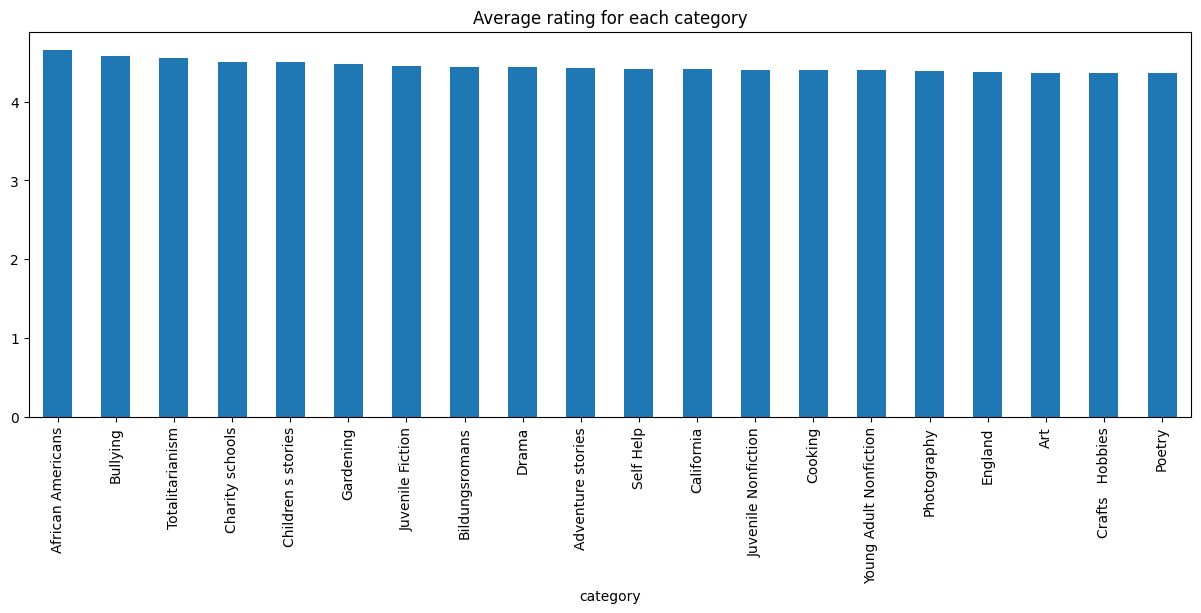

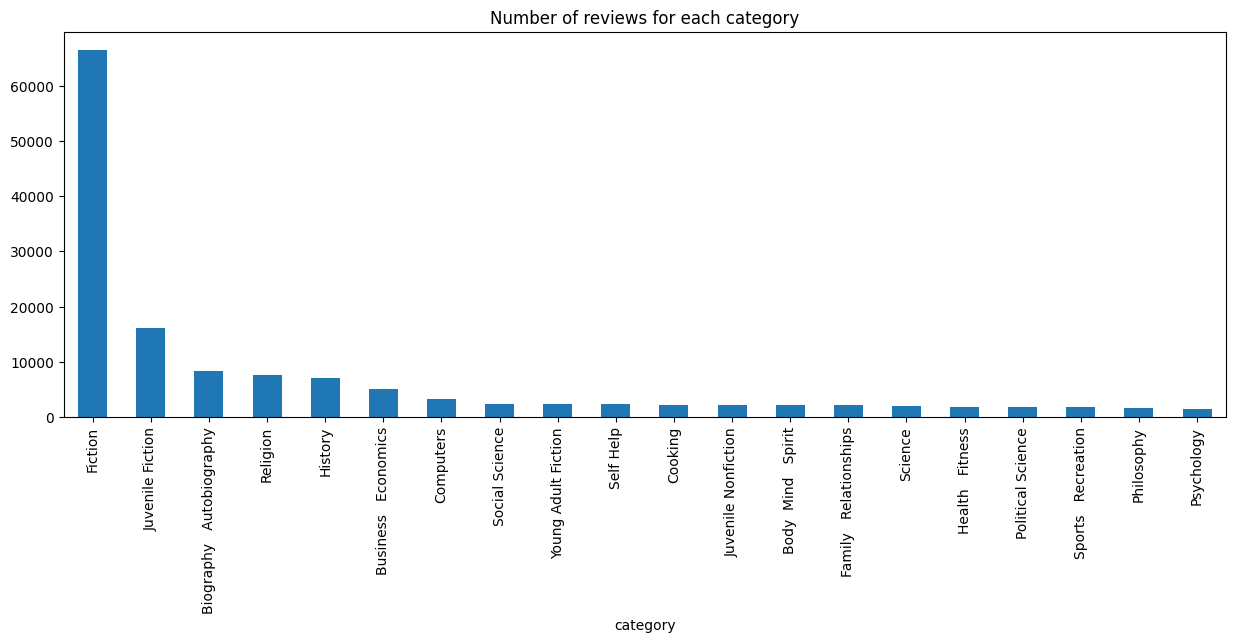

In [223]:
# Analyze the top 20 categories with the highest average rating
df_results_2.sort_values(by='avg_score', ascending = False, inplace=True)
df_results_2.head(20).plot(x='category', y='avg_score', kind='bar', figsize=(15,5), xlabel = 'category', title='Average rating for each category', legend=False)

# Analyze the top 20 categories with the highest number of reviews
df_results_2.sort_values(by='count', ascending = False, inplace=True)
df_results_2.head(20).plot(x='category', y='count', kind='bar', figsize=(15,5), xlabel = 'category', title='Number of reviews for each category', legend=False)

### Analysis of publishers

In [226]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$publisher',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1}
                                }
                           }

pipeline_project = {'$project':{
                         '_id':0,
                         'publisher':'$_id',
                         'avg_score':1,
                         'count': 1
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2 = pd.DataFrame(list(results_2))

In [227]:
df_results_2.head()

,avg_score,count,publisher
0,4.537572,173,Wyatt North Publishing LLC
1,4.318627,204,SUNY Press
2,4.253521,639,Everyman s Library
3,4.165354,127,Algonquin Books
4,4.279476,229,Workman Publishing


<AxesSubplot: title={'center': 'Number of reviews for each publisher'}, xlabel='publisher'>

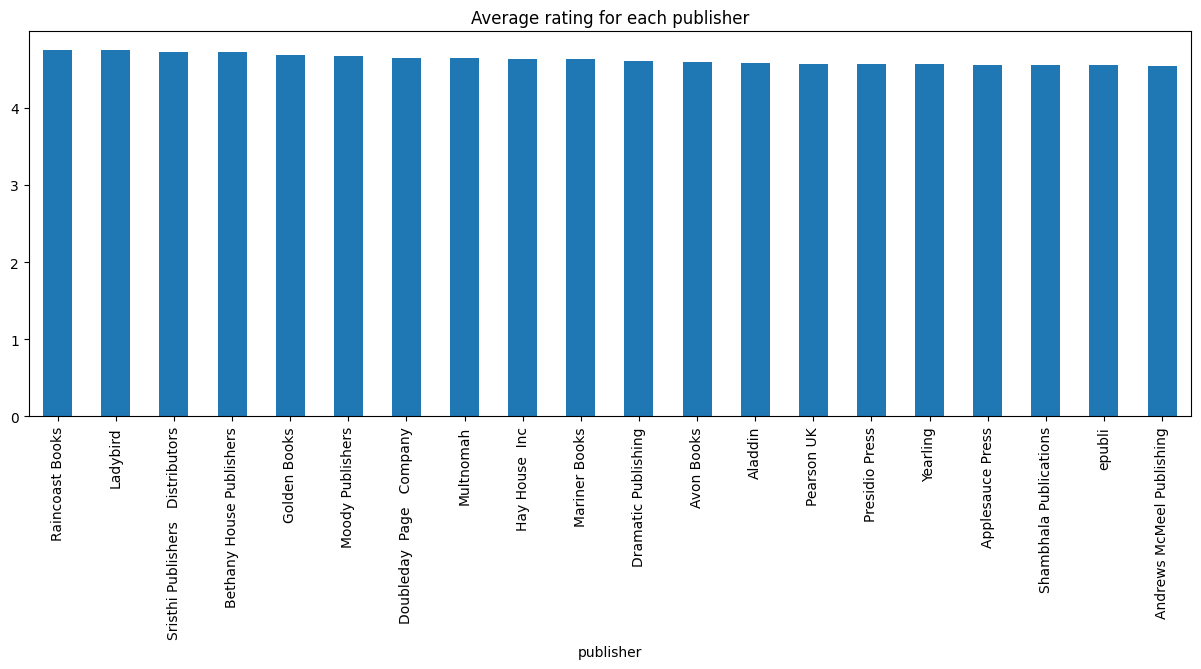

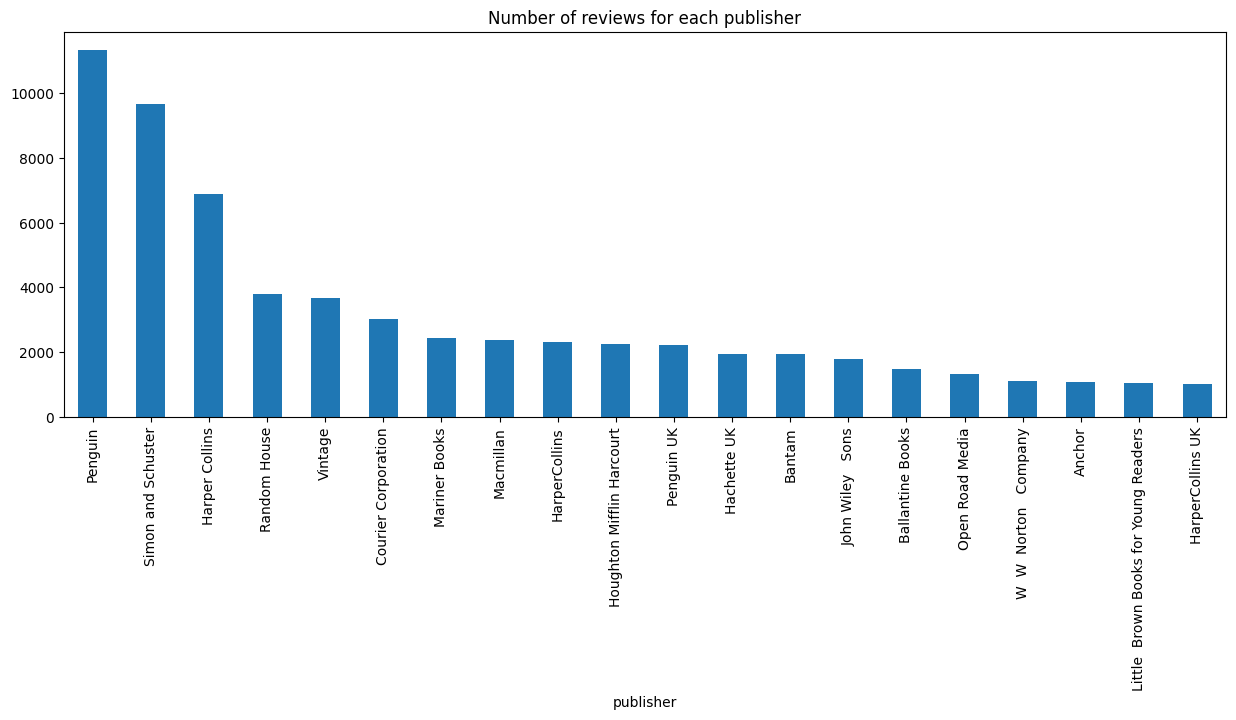

In [229]:
# Analyze the top 20 publishers with the highest average rating
df_results_2.sort_values(by='avg_score', ascending = False, inplace=True)
df_results_2.head(20).plot(x='publisher', y='avg_score', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Average rating for each publisher', legend=False)

# Analyze the top 20 publishers with the highest number of reviews
df_results_2.sort_values(by='count', ascending = False, inplace=True)
df_results_2.head(20).plot(x='publisher', y='count', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of reviews for each publisher', legend=False)